# Imports

In [1]:
import torch
import torch.nn as nn
import torchtext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union, Optional
from ast import literal_eval
from pathlib import Path

from torchtext.vocab import Vocab
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from datasets import load_metric

torch.manual_seed(432)

# Data loading

In [4]:
base_path = Path('..').resolve()
data_path = base_path / Path('data/interim/intermediate.tsv')
model_cktp_path = base_path / 'models' / 'encoder-decoder.pt'

tox_data = pd.read_csv(data_path, sep='\t', converters={'reference': literal_eval, 'translation': literal_eval})
tox_data.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"[if, alkar, is, flooding, her, with, psychic, ...","[if, alkar, floods, her, with, her, mental, wa...",0.785171,0.010309,0.014195,0.981983
1,"[now, you, ', re, getting, nasty, .]","[you, ', re, becoming, disgusting, .]",0.749687,0.071429,0.065473,0.999039
2,"[well, ,, we, could, spare, your, life, ,, for...","[well, ,, we, can, spare, your, life, .]",0.919051,0.268293,0.213313,0.985068
3,"[ah, !, monkey, ,, you, ', ve, got, to, snap, ...","[monkey, ,, you, have, to, wake, up, .]",0.664333,0.309524,0.053362,0.994215
4,"[i, ', ve, got, orders, to, put, her, down, .]","[i, have, orders, to, kill, her, .]",0.726639,0.181818,0.009402,0.999348


# Dataset

In [5]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
SPECIAL_SYMBOLS = ['<unk>', '<pad>', '<bos>', '<eos>']


class DeToxificationDataset(Dataset):
    """
    A dataset class for de-toxification data.

    Args:
        dataframe (pd.DataFrame): The input data in a Pandas DataFrame.
        vocab (Optional[Vocab]): Vocabulary for tokenization (default: None).
        min_tox (float): Minimum toxicity threshold (default: 0.75).
        max_length (int): Maximum allowed sequence length (default: 150).
        amount_of_pairs (Optional[int]): Number of pairs to use from the dataframe (default: None, using all).

    Attributes:
        dataframe (pd.DataFrame): The input data in a Pandas DataFrame.
        min_tox (float): Minimum toxicity threshold.
        max_length (int): Maximum allowed sequence length.
        amount_of_pairs (int): Number of pairs to use.
        reference (np.ndarray): Reference text data.
        translation (np.ndarray): Translation text data.
        vocab (Vocab): Vocabulary for tokenization.

    Methods:
        __init__(self, dataframe, vocab, min_tox, max_length, amount_of_pairs)
        _preprocess(self): Preprocess the data based on toxicity and sequence length.
        _create_vocab(self) -> Vocab: Create the vocabulary from the reference and translation text.
        _get_reference(self, index) -> list[int]: Get tokenized reference text at the given index.
        _get_translation(self, index) -> list[int]: Get tokenized translation text at the given index.
        __getitem__(self, index) -> tuple[list, list]: Get reference and translation at the given index.
        __len__(self) -> int: Get the length of the dataset.
    """

    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 vocab: Optional[Vocab] = None, 
                 min_tox: float = 0.75, 
                 max_length: int = 150,
                 amount_of_pairs: Optional[int] = None):
        self.dataframe = dataframe
        self.min_tox = min_tox
        self.max_length = max_length
        self.amount_of_pairs: int = amount_of_pairs or len(dataframe)
        self._preprocess()
        self.reference = self.dataframe['reference'].values[:self.amount_of_pairs]
        self.translation = self.dataframe['translation'].values[:self.amount_of_pairs]
        self.vocab: Vocab = vocab or self._create_vocab()

    def _preprocess(self):
        """
        Preprocess the input data based on toxicity and sequence length.
        """
        self.dataframe = self.dataframe[
            (self.dataframe['ref_tox'] >= self.min_tox) &
            (self.dataframe['trn_tox'] <= 1 - self.min_tox) &
            (self.dataframe['reference'].str.len() <= self.max_length) &
            (self.dataframe['translation'].str.len() <= self.max_length)
        ]

    def _create_vocab(self) -> Vocab:
        """
        Create a vocabulary from the reference and translation text.

        Returns:
            Vocab: A vocabulary for tokenization.
        """
        new_vocab = torchtext.vocab.build_vocab_from_iterator(
            iter(self.reference + self.translation),
            specials=SPECIAL_SYMBOLS
        )
        new_vocab.set_default_index(UNK_IDX)
        return new_vocab

    def _get_reference(self, index: int) -> list[int]:
        """
        Get tokenized reference text at the given index.

        Args:
            index (int): Index of the reference text.

        Returns:
            list[int]: Tokenized reference text.
        """
        return self.vocab(self.reference[index])

    def _get_translation(self, index: int) -> list[int]:
        """
        Get tokenized translation text at the given index.

        Args:
            index (int): Index of the translation text.

        Returns:
            list[int]: Tokenized translation text.
        """
        return self.vocab(self.translation[index])

    def __getitem__(self, index) -> tuple[list, list]:
        return self._get_reference(index), self._get_translation(index)

    def __len__(self) -> int:
        return self.amount_of_pairs

In [6]:
tox_dataset = DeToxificationDataset(tox_data, amount_of_pairs=50000)


# splitting dataset into train and validation
split_proportion = 0.9
size = int(len(tox_dataset) * split_proportion)
train_dataset, val_dataset = random_split(tox_dataset, [size, len(tox_dataset) - size])

In [7]:
def random_sample(some_dataset: DeToxificationDataset, vocab: Vocab):
    idx = np.random.randint(0, len(some_dataset))
    ref, trn = some_dataset[idx]
    print(' '.join(vocab.lookup_tokens(ref)))
    print(' '.join(vocab.lookup_tokens(trn)))


random_sample(train_dataset, tox_dataset.vocab)

pussy . sugar britches .
sugar princess !


In [8]:
len(train_dataset), len(val_dataset)

(45000, 5000)

# Dataloaders

In [9]:
def collate_batch(batch: list[np.ndarray]):
    ref_list, trn_list, trn_lengths = [], [], []

    for _ref, _trn in batch:
        ref_list.append(torch.tensor(_ref + [EOS_IDX]))
        trn_list.append(torch.tensor(_trn + [EOS_IDX]))
        trn_lengths.append(len(_trn))

    ref_list = torch.nn.utils.rnn.pad_sequence(ref_list, padding_value=PAD_IDX, batch_first=True)
    trn_list = torch.nn.utils.rnn.pad_sequence(trn_list, padding_value=PAD_IDX, batch_first=True)

    return ref_list, trn_list, trn_lengths


batch_size = 50
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

# Model

In [10]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism for sequence-to-sequence models.

    Args:
        hidden_dim (int): The dimension of the hidden state.

    Attributes:
        Wa (nn.Linear): Linear transformation for the query.
        Ua (nn.Linear): Linear transformation for the keys.
        Va (nn.Linear): Linear transformation for the attention scores.
        act (nn.Softmax): Softmax activation function for calculating attention weights.

    Methods:
        forward(self, query, keys) -> tuple[torch.Tensor, torch.Tensor]: Forward pass of the attention mechanism.
    """

    def __init__(self, hidden_dim: int):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)
        self.act = nn.Softmax(dim=-1)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate the attention scores and context vector.

        Args:
            query (torch.Tensor): The query tensor.
            keys (torch.Tensor): The keys tensor.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the context vector and attention weights.
        """
        scores: torch.Tensor = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = self.act(scores)
        context = torch.bmm(weights, keys)

        return context, weights

In [11]:
class EncoderRNN(nn.Module):
    """
    Encoder RNN for sequence-to-sequence models.

    Args:
        num_embeddings (int): The number of unique embeddings.
        embedding_dim (int): The dimension of the embedding space.
        hidden_dim (int): The dimension of the hidden state.
        lstm_layers (int): The number of LSTM layers.
        dropout_p (float): Dropout probability (default: 0.1).

    Attributes:
        lstm_layers (int): The number of LSTM layers.
        hidden_dim (int): The dimension of the hidden state.
        embedding (nn.Embedding): Embedding layer.
        rnn (nn.LSTM): LSTM layers.
        dropout (nn.Dropout): Dropout layer.
        device (Optional[torch.device]): Device to use (automatically determined).

    Methods:
        _get_initial_shape(self, x) -> tuple[int, ...]: Get the initial shape for LSTM.
        forward(self, x, h_0, c_0) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Forward pass of the encoder.
    """

    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 hidden_dim: int,
                 lstm_layers: int,
                 dropout_p: float = 0.1):
        super(EncoderRNN, self).__init__()
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim, hidden_size=hidden_dim, num_layers=lstm_layers,
            batch_first=True, dropout=dropout_p
        )
        self.dropout = nn.Dropout(dropout_p)
        self.device: Optional[torch.device] = None

    def _get_initial_shape(self, x: torch.Tensor) -> tuple[int, ...]:
        """
        Get the initial shape for LSTM based on the input tensor shape.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            tuple[int, ...]: Initial shape for LSTM.
        """
        if self.device is None:
            self.device = torch.device("cuda" if x.get_device() > -1 else "cpu")
        if len(x.shape) == 2:
            return self.lstm_layers, self.hidden_dim
        return self.lstm_layers, x.shape[0], self.hidden_dim

    def forward(self,
                x: torch.Tensor,
                h_0: Optional[torch.Tensor] = None,
                c_0: Optional[torch.Tensor] = None) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the encoder.

        Args:
            x (torch.Tensor): Input tensor.
            h_0 (Optional[torch.Tensor]): Initial hidden state tensor (default: None).
            c_0 (Optional[torch.Tensor]): Initial cell state tensor (default: None).

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Encoder output, final hidden state, and final cell state.
        """
        embedded = self.dropout(self.embedding(x))
        h_and_c_shape = self._get_initial_shape(embedded)
        if h_0 is None:
            h_0 = torch.zeros(h_and_c_shape).to(self.device)
        if c_0 is None:
            c_0 = torch.zeros(h_and_c_shape).to(self.device)

        output, (h_n, c_n) = self.rnn(embedded, (h_0, c_0))
        return output, h_n, c_n

In [12]:
class AttnDecoderRNN(nn.Module):
    """
    Attention Decoder RNN for sequence-to-sequence models.

    Args:
        num_embeddings (int): The number of unique embeddings.
        embedding_dim (int): The dimension of the embedding space.
        hidden_dim (int): The dimension of the hidden state.
        lstm_layers (int): The number of LSTM layers.
        dropout_p (float): Dropout probability (default: 0.1).

    Attributes:
        embedding (nn.Embedding): Embedding layer.
        rnn (nn.LSTM): LSTM layers.
        attention_h (BahdanauAttention): Attention mechanism.
        out (nn.Linear): Linear layer for output.
        dropout (nn.Dropout): Dropout layer.
        device (Optional[torch.device]): Device to use (automatically determined).

    Methods:
        forward(self, x, h_n, c_n, encoder_outputs, target_tensor, max_length) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
            Forward pass of the decoder.
        forward_step(self, decoder_input, decoder_h_0, decoder_c_0, encoder_outputs) -> tuple[torch.Tensor, ...]:
            Forward step of the decoder.
    """

    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 hidden_dim: int,
                 lstm_layers: int,
                 dropout_p: float = 0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.rnn = nn.LSTM(
            input_size=2 * embedding_dim, hidden_size=hidden_dim, num_layers=lstm_layers,
            batch_first=True, dropout=dropout_p
        )
        self.attention_h = BahdanauAttention(hidden_dim)
        self.out = nn.Linear(hidden_dim, num_embeddings)
        self.dropout = nn.Dropout(dropout_p)
        self.device: Optional[torch.device] = None

    def _set_device(self, x: torch.Tensor):
        if self.device is None:
            self.device = torch.device("cuda" if x.get_device() > -1 else "cpu")

    def forward(self,
                x: torch.Tensor,
                h_n: torch.Tensor,
                c_n: torch.Tensor,
                encoder_outputs: torch.Tensor,
                target_tensor: Optional[torch.Tensor] = None,
                max_length: Optional[int] = None):
        """
        Forward pass of the decoder.

        Args:
            x (torch.Tensor): Input tensor.
            h_n (torch.Tensor): Initial hidden state tensor.
            c_n (torch.Tensor): Initial cell state tensor.
            encoder_outputs (torch.Tensor): Outputs from the encoder.
            target_tensor (Optional[torch.Tensor]): Target tensor for teacher forcing.
            max_length (Optional[int]): Maximum sequence length (default: None).

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Decoder outputs, final hidden state, final cell state, and attention weights.
        """
        if max_length is None and target_tensor is None:
            raise ValueError("either max_length or target_tensor should be specified!")
        if target_tensor is not None:
            max_length = target_tensor.shape[1]
        self._set_device(x)

        b_size = x.shape[0]
        decoder_input = torch.empty((b_size, 1), dtype=torch.long).fill_(BOS_IDX).to(self.device)
        decoder_h_n = h_n
        decoder_c_n = c_n
        decoder_outputs = []
        attentions = []

        for i in range(max_length):
            decoder_output, decoder_h_n, decoder_c_n, attn_weights = self.forward_step(
                decoder_input, decoder_h_n, decoder_c_n, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_h_n, decoder_c_n, attentions

    def forward_step(self, 
                     decoder_input: torch.Tensor, 
                     decoder_h_0: torch.Tensor,
                     decoder_c_0: torch.Tensor,
                     encoder_outputs: torch.Tensor) -> tuple[torch.Tensor, ...]:
        """
        Forward step of the decoder.

        Args:
            decoder_input (torch.Tensor): Input tensor for the step.
            decoder_h_0 (torch.Tensor): Initial hidden state tensor.
            decoder_c_0 (torch.Tensor): Initial cell state tensor.
            encoder_outputs (torch.Tensor): Outputs from the encoder.

        Returns:
            tuple[torch.Tensor, ...]: Decoder output, final hidden state, final cell state, and attention weights.
        """
        embedded = self.dropout(self.embedding(decoder_input))

        query = decoder_h_0[-1].unsqueeze(0).permute(1, 0, 2)
        context, attn_weights = self.attention_h(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, (h_n, c_n) = self.rnn(input_lstm, (decoder_h_0, decoder_c_0))
        output = self.out(output)

        return output, h_n, c_n, attn_weights

In [13]:
class DeToxification(nn.Module):
    """
    DeToxification model for sequence-to-sequence tasks.

    Args:
        num_embeddings (int): The number of unique embeddings.
        embedding_dim (int): The dimension of the embedding space.
        hidden_dim (int): The dimension of the hidden state.
        lstm_layers (int): The number of LSTM layers.
        dropout_p (float): Dropout probability (default: 0.1).

    Attributes:
        enc (EncoderRNN): Encoder RNN.
        dec (AttnDecoderRNN): Attention Decoder RNN.

    Methods:
        forward(self, x, target, max_length) -> torch.Tensor: Forward pass of the DeToxification model.
    """

    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 hidden_dim: int,
                 lstm_layers: int,
                 dropout_p: float = 0.1):
        super(DeToxification, self).__init__()
        self.enc = EncoderRNN(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            lstm_layers=lstm_layers,
            dropout_p=dropout_p,
        )
        self.dec = AttnDecoderRNN(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            lstm_layers=lstm_layers,
            dropout_p=dropout_p,
        )

    def forward(self, 
                x: torch.Tensor, 
                target: Optional[torch.Tensor] = None, 
                max_length: Optional[int] = None) -> torch.Tensor:
        """
        Forward pass of the DeToxification model.

        Args:
            x (torch.Tensor): Input tensor.
            target (Optional[torch.Tensor]): Target tensor for teacher forcing.
            max_length (Optional[int]): Maximum sequence length (default: None).

        Returns:
            torch.Tensor: Decoder outputs.
        """
        out_e, h_n_e, c_n_e = self.enc(x)
        out_d, _, _, _ = self.dec(x, h_n_e, c_n_e, out_e, target, max_length)
        return out_d

# Training

In [14]:
def to_device(dev: torch.device, *args: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(dev) for t in args)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeToxification(
    num_embeddings=len(tox_dataset.vocab),
    embedding_dim=300,
    hidden_dim=300,
    lstm_layers=5,
    dropout_p=0.3,
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device

device(type='cuda')

In [15]:
# Load the BLUE metric
sacrebleu = load_metric("sacrebleu")
sacrebleu

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

In [16]:
def train(tr_model: nn.Module,
          epochs: int, 
          train_ld: DataLoader, 
          val_ld: DataLoader,
          optim: torch.optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss,
          vocab: Vocab,
          metric,
          dev: torch.device,
          ckpt_path: Union[Path, str]) -> tuple[list[float], list[float], float]:
    """
    Train a sequence-to-sequence model.

    Args:
        tr_model (nn.Module): The model to train.
        epochs (int): Number of training epochs.
        train_ld (DataLoader): Training data DataLoader.
        val_ld (DataLoader): Validation data DataLoader.
        optim (torch.optim.Optimizer): Optimizer for training.
        loss_fn (nn.CrossEntropyLoss): Loss function.
        vocab (Vocab): Vocabulary for tokenization.
        metric: Evaluation metric.
        dev (torch.device): Device for training.
        ckpt_path (Union[Path, str]): Path to save the best model checkpoint.

    Returns:
        Tuple[list[float], list[float], float]: Training losses, validation losses, and the best metric score.
    """
    tr_losses = []
    vl_losses = []
    _best = 0
    # loop for every epoch (training + evaluation)
    for epoch in range(1, epochs + 1):
        total_loss = 0
    
        # progress bar
        progress_train = tqdm(enumerate(train_ld, 1), desc="Loss: ", total=len(train_ld))
    
        # ----------------- TRAINING  --------------------
        # set model to training
        tr_model.train()
    
        for i, data in progress_train:
            inputs, targets = to_device(dev, *data[:-1])
    
            # training step for single batch
            optim.zero_grad()
    
            outputs = tr_model(inputs, targets)
            outputs = outputs.permute(0, 2, 1)
            loss = loss_fn(outputs, targets)
    
            # update running training loss
            current_loss = loss.item()
            total_loss += current_loss
    
            # optimizer run
            loss.backward()
            optim.step()
    
            # updating progress bar
            progress_train.set_description("Loss: {:.4f}".format(total_loss / i))

            # releasing unnecessary memory in GPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
        # releasing unnecessary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
        # ----------------- VALIDATION  -----------------
        # progress bar
        progress_val = tqdm(enumerate(val_ld, 1), desc="Loss: ", total=len(val_ld))
        val_loss_total = 0
        metric_total = 0
    
        # set model to evaluating (testing)
        tr_model.eval()
        with torch.no_grad():
            for i, data in progress_val:
                lengths = data[-1]
                inputs, targets = to_device(dev, *data[:-1])
    
                outputs = tr_model(inputs, max_length=targets.shape[1])
                outputs = outputs.permute(0, 2, 1)
    
                # update running validation loss
                val_loss_total += loss_function(outputs, targets).item()
                predicted = outputs.argmax(dim=1)

                predicted = predicted.detach().cpu().numpy()
                targets = targets.detach().cpu().numpy()
    
                predicted = [' '.join(vocab.lookup_tokens(row[:ln])) for row, ln in zip(predicted, lengths)]
                targets = [[' '.join(vocab.lookup_tokens(row[:ln]))] for row, ln in zip(targets, lengths)]
                metric_total += metric.compute(predictions=predicted, references=targets)['score']
    
                progress_val.set_description("Loss: {:.4f}, Sacrebleu: {:.4f}".format(val_loss_total / i, metric_total / i))

                # releasing unnecessary memory in GPU
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        if _best < metric_total / len(val_ld):
            torch.save(tr_model.state_dict(), ckpt_path)
            _best = metric_total / len(val_ld)

        print(
            f"Epoch {epoch}/{epochs}, "
            f"training loss: {total_loss / len(train_ld):.4f}, "
            f"validation loss: {val_loss_total / len(val_ld):.4f}, "
            f"sacrebleu: {metric_total / len(val_ld):.4f}"
        )
        tr_losses.append(total_loss / len(train_ld))
        vl_losses.append(val_loss_total / len(val_ld))

    return tr_losses, vl_losses, _best

In [17]:
train_losses, val_losses, best_score = train(
    tr_model=model,
    epochs=10,
    train_ld=train_dataloader,
    val_ld=val_dataloader,
    optim=optimizer,
    loss_fn=loss_function,
    vocab=tox_dataset.vocab,
    metric=sacrebleu,
    dev=device,
    ckpt_path=model_cktp_path
)

Loss: 2.0313, Sacrebleu: 0.4438: 100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


Epoch 1/10, training loss: 2.1976, validation loss: 2.0313, sacrebleu: 0.4438


Loss: 1.9667, Sacrebleu: 0.6741: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


Epoch 2/10, training loss: 1.9752, validation loss: 1.9667, sacrebleu: 0.6741


Loss: 2.7209, Sacrebleu: 2.9515: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Epoch 3/10, training loss: 1.6245, validation loss: 2.7209, sacrebleu: 2.9515


Loss: 2.8196, Sacrebleu: 4.1398: 100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


Epoch 4/10, training loss: 1.4448, validation loss: 2.8196, sacrebleu: 4.1398


Loss: 2.9078, Sacrebleu: 4.6309: 100%|██████████| 100/100 [00:10<00:00,  9.09it/s]


Epoch 5/10, training loss: 1.3320, validation loss: 2.9078, sacrebleu: 4.6309


Loss: 3.0431, Sacrebleu: 5.4558: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


Epoch 6/10, training loss: 1.2645, validation loss: 3.0431, sacrebleu: 5.4558


Loss: 3.1335, Sacrebleu: 6.2904: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


Epoch 7/10, training loss: 1.1885, validation loss: 3.1335, sacrebleu: 6.2904


Loss: 3.2403, Sacrebleu: 6.7012: 100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


Epoch 8/10, training loss: 1.1282, validation loss: 3.2403, sacrebleu: 6.7012


Loss: 3.2296, Sacrebleu: 6.8398: 100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


Epoch 9/10, training loss: 1.0819, validation loss: 3.2296, sacrebleu: 6.8398


Loss: 3.3665, Sacrebleu: 7.4520: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


Epoch 10/10, training loss: 1.0368, validation loss: 3.3665, sacrebleu: 7.4520


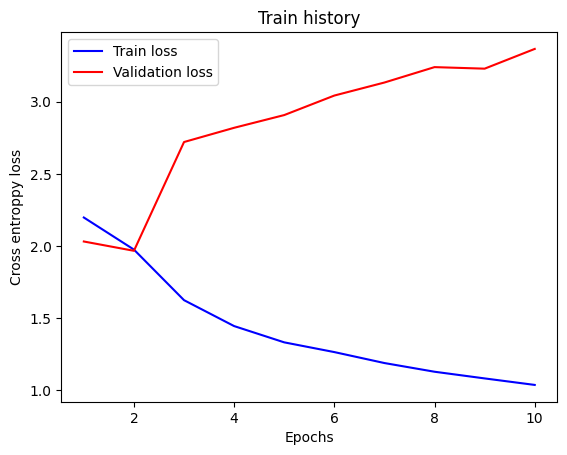

In [18]:
epochs_arr = np.arange(1, len(train_losses) + 1, 1)
plt.title('Train history')
plt.plot(epochs_arr, train_losses, c='b', label='Train loss')
plt.plot(epochs_arr, val_losses, c='r', label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross entroppy loss')
plt.show()

In [16]:
model = DeToxification(
    num_embeddings=len(tox_dataset.vocab),
    embedding_dim=300,
    hidden_dim=300,
    lstm_layers=5,
    dropout_p=0.3,
)
model.load_state_dict(torch.load(model_cktp_path))
model.to(device)

DeToxification(
  (enc): EncoderRNN(
    (embedding): Embedding(32331, 300)
    (rnn): LSTM(300, 300, num_layers=5, batch_first=True, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dec): AttnDecoderRNN(
    (embedding): Embedding(32331, 300)
    (rnn): LSTM(600, 300, num_layers=5, batch_first=True, dropout=0.3)
    (attention_h): BahdanauAttention(
      (Wa): Linear(in_features=300, out_features=300, bias=True)
      (Ua): Linear(in_features=300, out_features=300, bias=True)
      (Va): Linear(in_features=300, out_features=1, bias=True)
      (act): Softmax(dim=-1)
    )
    (out): Linear(in_features=300, out_features=32331, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [17]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

def de_toxification(tr_model: nn.Module, text: str, vocab: Vocab, dev: torch.device, max_length: int = 50) -> str:
    """
    De-toxify a given text using a sequence-to-sequence model.

    Args:
        tr_model (nn.Module): The trained model for de-toxification.
        text (str): The input text to de-toxify.
        vocab (Vocab): Vocabulary for tokenization.
        dev (torch.device): Device for inference.
        max_length (int): Maximum length of the output text (default: 50).

    Returns:
        str: The de-toxified text.
    """
    text = text.lower()
    garbage = [
        '^', '&', '*', '%', '@', '#', '$', '_', '+', '-', '=', '>', '<', ':', '~'
    ]
    for symbol in garbage:
        text = text.replace(symbol, '')
    text = text.replace('...', '.')
    tokens = tokenizer(text)
    tokens_idx = torch.tensor(vocab(tokens) + [EOS_IDX]).unsqueeze(0).to(device)
    output = tr_model(tokens_idx, max_length=max_length)
    output = output.permute(0, 2, 1)

    predicted = output.argmax(dim=1)
    predicted = predicted.detach()
    if dev.type == 'cuda':
        predicted = predicted.cpu()
    predicted = predicted.numpy()
    predicted = predicted[0]

    end_idx = predicted.tolist().index(EOS_IDX)
    predicted = predicted[:end_idx] if end_idx > -1 else predicted
    predicted = ' '.join(vocab.lookup_tokens(predicted))

    return predicted

In [21]:
de_tox = de_toxification(model, "You are dirty bastard!", tox_dataset.vocab, device)
print(de_tox)

you ' re a monster !
